In [2]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `c:\Users\matti\Documents\TUe\Thesis\ThesisParallelMP`


In [3]:
using RxInfer, Distributions, LinearAlgebra, Random, Plots, Parameters, ProgressMeter

In [4]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (8, 0)


(8, 0)

In [5]:
includet("../parallel.jl")

In [6]:
function generate_ar_data(rng, n, θ, γ, τ)
    order        = length(θ)
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)

    γ_std = sqrt(inv(γ))
    τ_std = sqrt(inv(τ))

    states[1] = randn(rng, order)

    for i in 2:(n + 3order)
        states[i]       = vcat(rand(rng, Normal(dot(θ, states[i - 1]), γ_std)), states[i-1][1:end-1])
        observations[i] = rand(rng, Normal(states[i][1], τ_std))
    end

    return states[1+3order:end], observations[1+3order:end]
end

generate_ar_data (generic function with 1 method)

In [27]:
@model function lar_model(T::Type, n, order, c, τ, prod_strategy, pipeline)
    # We create a sequence of random variables for hidden states
    x = randomvar(n) where { prod_strategy = prod_strategy }
    # As well a sequence of observartions
    y = datavar(Float64, n)

    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ)

    γ  = randomvar() where { prod_strategy = prod_strategy }
    θ  = randomvar() where { prod_strategy = prod_strategy }
    x0 = randomvar() where { prod_strategy = prod_strategy }

    # Prior for first state
    if T === Multivariate
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ MvNormal(μ = zeros(order), Λ = diageye(order))
        x0 ~ MvNormal(μ = zeros(order), Λ = diageye(order))
    else
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ Normal(μ = 0.0, γ = 1.0)
        x0 ~ Normal(μ = 0.0, γ = 1.0)
    end

    x_prev = x0

    for i in 1:n

        x[i] ~ AR(x_prev, θ, γ) where { pipeline = pipeline }

        if T === Multivariate
            y[i] ~ Normal(μ = dot(ct, x[i]), γ = cτ) #where { pipeline = pipeline }
        else
            y[i] ~ Normal(μ = ct * x[i], γ = cτ) #where { pipeline = pipeline }
        end

        x_prev = x[i]
    end
end

In [8]:
@constraints function ar_constraints()
    q(x0, x, θ, γ) = q(x0, x)q(θ)q(γ)
end

@meta function ar_meta(artype, order, stype)
    AR() -> ARMeta(artype, order, stype)
end

ar_meta (generic function with 1 method)

In [9]:
martype = Multivariate
moptions = (limit_stack_depth = 100, )
mreturnvars = (x = KeepLast(), γ = KeepEach(), θ = KeepEach())
mconstraints = ar_constraints();

In [10]:
# Seed for reproducibility
seed = 123
rng  = MersenneTwister(seed)
n = 100

# AR process parameters
real_γ = 1.0
real_τ = 0.5
real_θ = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [11]:
function execute_benchmark(f::F, n = 1000) where { F }

    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)

    for i in 1:n
        times[i] = f()
    end

    return times
end

execute_benchmark (generic function with 2 methods)

In [12]:
function benchmark_rule(ar_order; n = 1000)
    times = Vector{Float64}(undef, n)

    for i in 1:n
        start_time = time_ns()

        m_y = MvNormalMeanCovariance(zeros(ar_order), diageye(ar_order))
        m_x = MvNormalMeanCovariance(zeros(ar_order), diageye(ar_order))
        q_θ = MvNormalMeanCovariance(zeros(ar_order), diageye(ar_order))
        q_γ = Gamma(1, 1)
        meta = ARMeta(martype, ar_order, ARsafe())

        x_rule = @call_rule AR(:x, ReactiveMP.Marginalisation) (m_y = m_y, q_θ = q_θ, q_γ = q_γ, meta = meta)
        y_rule = @call_rule AR(:y, ReactiveMP.Marginalisation) (m_x = m_x, q_θ = q_θ, q_γ = q_γ, meta = meta)
        x_y_rule = @call_marginalrule AR(:y_x) (m_y = m_y, m_x = m_x, q_θ = q_θ, q_γ = q_γ, meta = meta)
        θ_rule = @call_rule AR(:θ, ReactiveMP.Marginalisation) (q_y_x = x_y_rule, q_γ = q_γ, meta = meta)
        γ_rule = @call_rule AR(:γ, ReactiveMP.Marginalisation) (q_y_x = x_y_rule, q_θ = q_θ, meta = meta)

        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [13]:
function prepare_benchmark(prod, pipeline, order, niterations = 100)
    return () -> begin
        timing = Ref(0.0)
        current_iter = Ref(0.0)

        mc = ReactiveMP.ar_unit(martype, order)
        mmeta = ar_meta(martype, order, ARsafe())
        minitmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = MvNormalMeanPrecision(zeros(order), diageye(order)))
        states, observations = generate_ar_data(rng, n, real_θ, real_γ, real_τ);
        mdata = (y = observations, )

        infer(
            model = lar_model(martype, n, order, mc, real_τ, prod, pipeline),
            data  = mdata,
            callbacks = (
                before_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations    = niterations,
            constraints   = mconstraints,
            meta          = mmeta,
            options       = moptions,
            initmarginals = minitmarginals,
            returnvars    = mreturnvars,
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 2 methods)

In [14]:
function run_big_benchmark(combinations, orders; nsamples = 10, niterations = 100)
    return map(orders) do order

        results = Dict()
        results[:rule] = benchmark_rule(order)

        @showprogress for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], order, niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (order, results)
    end
end

run_big_benchmark (generic function with 1 method)

In [29]:
combinations = [
    :sequential => (nothing, nothing),
    #:parallel_fifo_prod => (CustomProdStrategy(fifo_prod), nothing),
    #:parallel_pipeline => (nothing, ThreadsPipelineStage()),
    #:parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    #:parallel_frfo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_reusing => (nothing, ThreadsReusingPipelineStage(vague(MvNormalMeanCovariance, 2)))
]

2-element Vector{Pair{Symbol, Tuple{Nothing, Any}}}:
       :sequential => (nothing, nothing)
 :parallel_reusing => (nothing, ThreadsReusingPipelineStage{GammaShapeRate{Float64}}(GammaShapeRate{Float64}(a=1.0, b=1.0e-12)))

In [25]:
BLAS.set_num_threads(1)

In [30]:
results = run_big_benchmark(combinations, [2, ]; niterations = 25);

LoadError: `ProductOf` object cannot be used as a functional form in inference backend. Use form constraints to restrict the functional form of marginal posteriors.

In [50]:
orders = getindex.(results, 1)
benchmarks = getindex.(results, 2)
labels = [first.(combinations); :rule]

points = map(labels) do label
    label => minimum.(getindex.(benchmarks, label))
end |> Dict

Dict{Symbol, Vector{Float64}} with 3 entries:
  :sequential       => [5.71621e7, 1.98225e8, 5.40542e8, 1.14922e9, 2.11676e9]
  :rule             => [3.9, 18.5, 66.4, 156.5, 295.9]
  :parallel_reusing => [6.09053e7, 2.05881e8, 5.44872e8, 1.18698e9, 2.16967e9]

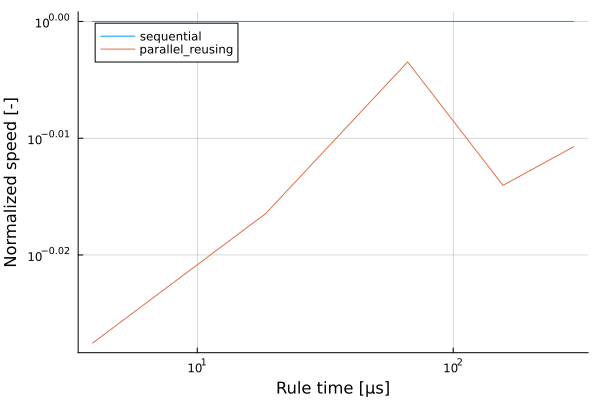

In [51]:
p = plot(
    xaxis=:log,
    yaxis=:log,
    legend=:topleft,
    xlabel="Rule time [μs]",
    ylabel="Normalized speed [-]",
    #yticks=([1:10;], [string(a) for a in 1:10]),
    #ylim = (0.5, 10),
    gridalpha=0.3,
)

for (key, values) in pairs(points)
    if key != :rule
        plot!(p, points[:rule], points[:sequential] ./ values, label = string(key))
    end
end

p